In [ ]:
from google.colab import files
uploaded = files.upload()


Saving SWaT_Dataset_Attack_v0.xlsx to SWaT_Dataset_Attack_v0.xlsx


In [ ]:
import pandas as pd

# Чтение Excel файла
df = pd.read_excel("SWaT_Dataset_Attack_v0.xlsx", engine='openpyxl')
print(df.head())


                Unnamed: 0 Unnamed: 1 Unnamed: 2 Unnamed: 3 Unnamed: 4  \
0                  t_stamp     FIT101     LIT101      MV101       P101   
1   28/12/2015 10:00:00 AM   2.427057   522.8467          2          2   
2   28/12/2015 10:00:01 AM   2.446274    522.886          2          2   
3   28/12/2015 10:00:02 AM   2.489191   522.8467          2          2   
4   28/12/2015 10:00:03 AM    2.53435   522.9645          2          2   

  Unnamed: 5 Unnamed: 6 Unnamed: 7 Unnamed: 8 Unnamed: 9  ... Unnamed: 43  \
0       P102     AIT201     AIT202     AIT203     FIT201  ...        P501   
1          1   262.0161   8.396437   328.6337   2.445391  ...           2   
2          1   262.0161   8.396437   328.6337   2.445391  ...           2   
3          1   262.0161   8.394514   328.6337   2.442316  ...           2   
4          1   262.0161   8.394514   328.6337   2.442316  ...           2   

  Unnamed: 44 Unnamed: 45 Unnamed: 46 Unnamed: 47 Unnamed: 48 Unnamed: 49  \
0        P502  

In [ ]:
# Step 2: Import necessary libraries and read the dataset
# import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Read the Excel file (make sure openpyxl is used as engine)
# df = pd.read_excel("SWaT_Dataset_Attack_v0.xlsx", engine="openpyxl")

# Display shape and head for sanity check
print("Dataset shape:", df.shape)
print(df.head())


Dataset shape: (449920, 53)
                Unnamed: 0 Unnamed: 1 Unnamed: 2 Unnamed: 3 Unnamed: 4  \
0                  t_stamp     FIT101     LIT101      MV101       P101   
1   28/12/2015 10:00:00 AM   2.427057   522.8467          2          2   
2   28/12/2015 10:00:01 AM   2.446274    522.886          2          2   
3   28/12/2015 10:00:02 AM   2.489191   522.8467          2          2   
4   28/12/2015 10:00:03 AM    2.53435   522.9645          2          2   

  Unnamed: 5 Unnamed: 6 Unnamed: 7 Unnamed: 8 Unnamed: 9  ... Unnamed: 43  \
0       P102     AIT201     AIT202     AIT203     FIT201  ...        P501   
1          1   262.0161   8.396437   328.6337   2.445391  ...           2   
2          1   262.0161   8.396437   328.6337   2.445391  ...           2   
3          1   262.0161   8.394514   328.6337   2.442316  ...           2   
4          1   262.0161   8.394514   328.6337   2.442316  ...           2   

  Unnamed: 44 Unnamed: 45 Unnamed: 46 Unnamed: 47 Unnamed: 48 Un

In [ ]:
# Step 3: Preprocessing

# Drop timestamp and state columns if they exist
# NOTE: Changed 't_stamp' to ' Timestamp' and added 't_stamp' to handle potential variation.
df_clean = df.drop(columns=[" Timestamp", "State", "t_stamp"], errors='ignore')

# Replace commas with dots if needed (in string values)
# Remove leading/trailing spaces when replacing commas with dots
# Convert all columns to float, skipping columns that can't be converted
# Explicitly handle potential index column
if 'Unnamed: 0' in df_clean.columns:
    df_clean = df_clean.drop(columns=['Unnamed: 0'])

# Iterate through columns and attempt conversion
for col in df_clean.columns:
    # Attempt conversion, replacing commas with dots and handling errors
    try:
        df_clean[col] = pd.to_numeric(df_clean[col].astype(str).str.replace(',', '.', 1), errors='coerce')
    except (TypeError, ValueError):
        print(f"Skipping conversion of column {col} due to non-numeric values.")
# Impute missing values using the mean of each column
df_clean = df_clean.fillna(df_clean.mean())

# Check for missing values
print("Total missing values:", df_clean.isnull().sum().sum())

Total missing values: 449920


In [ ]:
# Step 4: Train the Isolation Forest model
model = IsolationForest(n_estimators=100, contamination=0.02, random_state=42)
model.fit(df_clean)

# Predict anomalies
preds = model.predict(df_clean)  # -1 = anomaly, 1 = normal
df['Prediction'] = preds

# Display prediction counts
print(df['Prediction'].value_counts())


Prediction
 1    440921
-1      8999
Name: count, dtype: int64


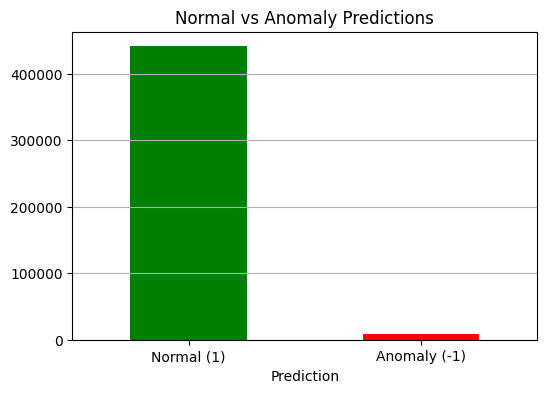

In [ ]:
# Step 5: Optional - Visualize number of anomalies
plt.figure(figsize=(6, 4))
df['Prediction'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title("Normal vs Anomaly Predictions")
plt.xticks([0, 1], ['Normal (1)', 'Anomaly (-1)'], rotation=0)
plt.grid(axis='y')
plt.show()


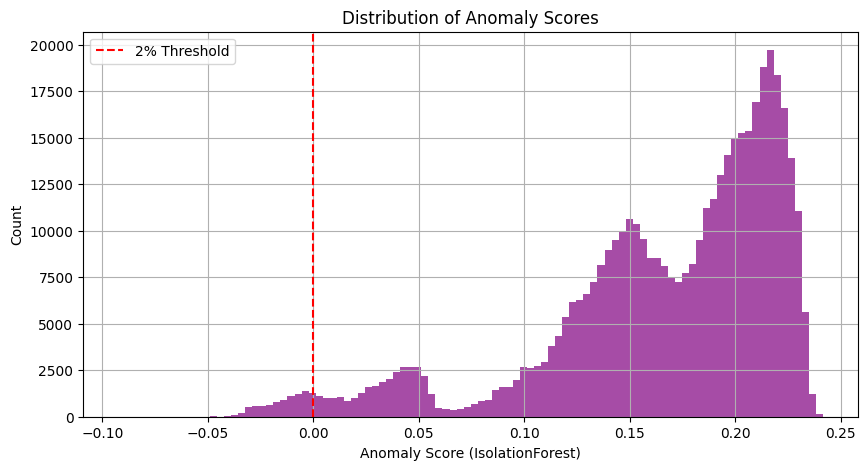

In [ ]:
import numpy as np  # Add this line to import NumPy
scores = model.decision_function(df_clean)  # Чем меньше — тем более аномально
plt.figure(figsize=(10, 5))
plt.hist(scores, bins=100, color='purple', alpha=0.7)
plt.axvline(x=np.percentile(scores, 2), color='red', linestyle='--', label='2% Threshold')
plt.title("Distribution of Anomaly Scores")
plt.xlabel("Anomaly Score (IsolationForest)")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Добавим anomaly score в датафрейм
df['Anomaly_Score'] = scores

# Отсортируем по аномальности (от самого "аномального" к наименее)
top_anomalies = df[df['Prediction'] == -1].sort_values(by='Anomaly_Score').head(10)

print("Top 10 most anomalous records:")

# Assuming the first column ('Unnamed: 0') in the original df is the timestamp
# If this is incorrect, change 'Unnamed: 0' to the actual timestamp column name
timestamp_col = 'Unnamed: 0'

# Now use the found timestamp_col to select from top_anomalies
print(top_anomalies[[timestamp_col, 'Anomaly_Score'] + df_clean.columns[:5].tolist()])

Top 10 most anomalous records:
                   Unnamed: 0  Anomaly_Score Unnamed: 1 Unnamed: 2 Unnamed: 3  \
16059   28/12/2015 2:27:38 PM      -0.092428   2.631393   541.0208          2   
16060   28/12/2015 2:27:39 PM      -0.092428    2.62723    540.746          2   
16061   28/12/2015 2:27:40 PM      -0.092428   2.622426   540.1572          2   
16062   28/12/2015 2:27:41 PM      -0.092428   2.607693   539.8432          2   
16065   28/12/2015 2:27:44 PM      -0.091952   2.544278   540.0002          2   
16064   28/12/2015 2:27:43 PM      -0.091477   2.562534   540.0394          2   
16063   28/12/2015 2:27:42 PM      -0.091477   2.577907    539.804          2   
16058   28/12/2015 2:27:37 PM      -0.089611   2.646126   540.9815          2   
16057   28/12/2015 2:27:36 PM      -0.088664   2.670147    540.589          2   
16054   28/12/2015 2:27:33 PM      -0.086302   2.603529   540.8245          2   

      Unnamed: 4 Unnamed: 5  
16059          2          1  
16060          2 

In [ ]:
# Попробуем загрузить с пропуском первых 3 строк
df = pd.read_excel("SWaT_Dataset_Attack_v0.xlsx", engine="openpyxl", header=None, skiprows=3)

# Очистим пробелы в названиях колонок
df.columns = df.iloc[0].str.strip()  # Используем первую строку как заголовки

# Удалим первую строку (так как она использовалась как заголовки)
df = df.drop(0)

# Убедимся, что колонка 't_stamp' есть и конвертируем её в datetime
if 't_stamp' in df.columns:
    df['t_stamp'] = pd.to_datetime(df['t_stamp'], errors='coerce')
    df = df.dropna(subset=['t_stamp'])  # Удалим строки с пропущенными датами

    # Построим график по FIT101
    plt.figure(figsize=(14, 5))
    plt.plot(df['t_stamp'], df['FIT101'], label='FIT101', alpha=0.6)

    # Покажем аномалии
    anomaly_mask = df['Prediction'] == -1
    plt.scatter(df.loc[anomaly_mask, 't_stamp'],
                df.loc[anomaly_mask, 'FIT101'],
                color='red', label='Anomalies', s=20)

    plt.title('Anomalies in FIT101 Sensor Over Time')
    plt.xlabel('Time')
    plt.ylabel('FIT101 Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print("🔴 Колонка 't_stamp' не найдена. Вот какие колонки есть:")
    print(df.columns.tolist())


🔴 Колонка 't_stamp' не найдена. Вот какие колонки есть:
['28/12/2015 10:00:01 AM', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 'Normal']
